In [21]:
import pandas as pd
import hvplot.pandas
import sqlalchemy
from dotenv import load_dotenv
from pathlib import Path
import requests
import json
import os
import time
from panel import interact

load_dotenv('data/.env')
AVAPI = os.getenv('Alpha_Vantage_API')

database_connection_string = 'sqlite:///SP500.db'
engine = sqlalchemy.create_engine(database_connection_string)

### Daily Market Cap by Constituent

Each stock's Market Capitalization can be pulled daily from a y-charts csv.  Requires a subscription.

In [22]:
MRK_MC_Data = pd.read_csv(Path("Data/mrk_market_cap_data_short.csv"), index_col='Period', parse_dates=True, infer_datetime_format=True)
MRK_MC_Data = MRK_MC_Data.astype({'Market Cap':'float64'})
MRK_MC_Data.head()

,Market Cap
Period,
2022-02-18,192906.3356
2022-02-17,192881.0762
2022-02-16,195053.3880
2022-02-15,196543.6949
2022-02-14,193158.9300


In [23]:
MRK_MC_Normalized = MRK_MC_Data / MRK_MC_Data.min()
MRK_MC_Normalized

,Market Cap
Period,
2022-02-18,1.705847
2022-02-17,1.705624
2022-02-16,1.724833
2022-02-15,1.738012
2022-02-14,1.708081
...,...
2012-01-09,1.032298
2012-01-06,1.034449
2012-01-05,1.041709


<AxesSubplot:xlabel='Period'>

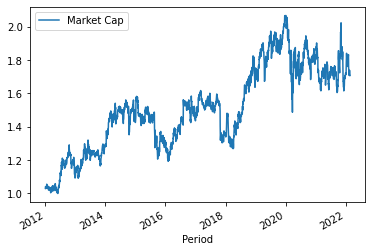

In [25]:
MRK_MC_Normalized.plot()

In [28]:
SP500_Cons_Adj = pd.read_sql_table('SP500 Cons Adjusted', engine)
MRK_DA_Data = SP500_Cons_Adj[['index','MRK']]
MRK_DA_Data.set_index('index', inplace=True)
MRK_DA_Data.index = pd.to_datetime(MRK_DA_Data.index)
MRK_DA_Data = MRK_DA_Data[MRK_DA_Data.index > '2012-01-01']
MRK_DA_Normalized =  MRK_DA_Data / MRK_DA_Data.min()
MRK_DA_Normalized.rename(columns={'MRK':'Daily Adjusted'}, inplace=True)

In [75]:
MRK_DA_Normalized.hvplot(title='MRK Daily Adjusted Normalized')

:Curve   [index]   (Daily Adjusted)

In [30]:
SP500_Data = pd.read_csv(Path("Data/SP500to2012.csv"), index_col='Date', parse_dates=True, infer_datetime_format=True)
SP500_Data = SP500_Data.astype({'Close':'float64'})
SP500_Normalized = SP500_Data / SP500_Data.min()
SP500_Normalized.rename(columns={'Close':'S&P500 Close'}, inplace=True)
SP500_Normalized.head()

,S&P500 Close
Date,
2012-01-31,1.026893
2012-02-01,1.036032
2012-02-02,1.037166
2012-02-03,1.052314
2012-02-06,1.051868


In [77]:
MRK_Master_Normalized = pd.merge(SP500_Normalized, MRK_DA_Normalized, how='outer', left_index=True, right_index=True)

In [78]:
MRK_Master_Normalized = pd.merge(MRK_Master_Normalized, MRK_MC_Normalized, how='outer', left_index=True, right_index=True)

In [79]:
MRK_Master_Normalized.dropna(inplace=True)
MRK_Master_Normalized

,S&P500 Close,Daily Adjusted,Market Cap
2012-01-31,1.026893,1.025730,1.030144
2012-02-01,1.036032,1.035379,1.039834
2012-02-02,1.037166,1.030287,1.034720
2012-02-03,1.052314,1.028411,1.032836
2012-02-06,1.051868,1.029215,1.033643
...,...,...,...
2022-01-31,3.533184,3.173031,1.819987
2022-02-01,3.557432,3.190166,1.829815
2022-02-02,3.590952,3.193671,1.831825
2022-02-03,3.503365,3.076843,1.764816


In [81]:
MRK_Master_Normalized.hvplot(ylabel='normalized growth', title = 'MRK')

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [59]:
MRK_Master_Normalized['DA/MC'] = MRK_Master_Normalized['Daily Adjusted'] / MRK_Master_Normalized['Market Cap']

In [60]:
MRK_Master_Normalized['DA/MC'].hvplot()

:Curve   [index]   (DA/MC)

In [61]:
MRK_Master_Normalized['DA/SP500'] = MRK_Master_Normalized['Daily Adjusted'] / MRK_Master_Normalized['S&P500 Close']

In [62]:
MRK_Master_Normalized[{'DA/MC','DA/SP500'}].hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [63]:
MRK_Master_Normalized

,S&P500 Close,Daily Adjusted,Market Cap,DA/MC,DA/SP500
2012-01-31,1.026893,1.025730,1.030144,0.995716,0.998868
2012-02-01,1.036032,1.035379,1.039834,0.995716,0.999370
2012-02-02,1.037166,1.030287,1.034720,0.995716,0.993367
2012-02-03,1.052314,1.028411,1.032836,0.995716,0.977284
2012-02-06,1.051868,1.029215,1.033643,0.995716,0.978463
...,...,...,...,...,...
2022-01-31,3.533184,3.173031,1.819987,1.743436,0.898066
2022-02-01,3.557432,3.190166,1.829815,1.743436,0.896761
2022-02-02,3.590952,3.193671,1.831825,1.743436,0.889366
2022-02-03,3.503365,3.076843,1.764816,1.743436,0.878254


In [64]:
SP500_Cons_Close = pd.read_sql_table('SP500 Cons Closing', engine)
MRK_DC_Data = SP500_Cons_Close[['index','MRK']]
MRK_DC_Data.set_index('index', inplace=True)
MRK_DC_Data.index = pd.to_datetime(MRK_DC_Data.index)
MRK_DC_Data = MRK_DC_Data[MRK_DC_Data.index > '2012-01-01']
MRK_DC_Normalized =  MRK_DC_Data / MRK_DC_Data.min()
MRK_DC_Normalized.rename(columns={'MRK':'Daily Close'}, inplace=True)

<AxesSubplot:xlabel='index'>

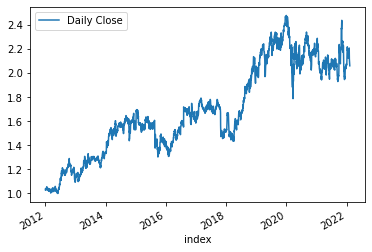

In [65]:
MRK_DC_Normalized.plot()

In [66]:
MRK_Master_Normalized.head()

,S&P500 Close,Daily Adjusted,Market Cap,DA/MC,DA/SP500
2012-01-31,1.026893,1.025730,1.030144,0.995716,0.998868
2012-02-01,1.036032,1.035379,1.039834,0.995716,0.999370
2012-02-02,1.037166,1.030287,1.034720,0.995716,0.993367
2012-02-03,1.052314,1.028411,1.032836,0.995716,0.977284
2012-02-06,1.051868,1.029215,1.033643,0.995716,0.978463


In [67]:
MRK_Master_Normalized = pd.merge(MRK_Master_Normalized, MRK_DC_Normalized, how='outer', left_index=True, right_index=True)

In [68]:
MRK_Master_Normalized.dropna(inplace=True)

In [69]:
MRK_Master_Normalized.head()

,S&P500 Close,Daily Adjusted,Market Cap,DA/MC,DA/SP500,Daily Close
2012-01-31,1.026893,1.025730,1.030144,0.995716,0.998868,1.029317
2012-02-01,1.036032,1.035379,1.039834,0.995716,0.999370,1.038999
2012-02-02,1.037166,1.030287,1.034720,0.995716,0.993367,1.033889
2012-02-03,1.052314,1.028411,1.032836,0.995716,0.977284,1.032006
2012-02-06,1.051868,1.029215,1.033643,0.995716,0.978463,1.032813


In [70]:
MRK_Master_Normalized['DC/MC'] = MRK_Master_Normalized['Daily Close'] / MRK_Master_Normalized['Market Cap']

In [71]:
MRK_Master_Normalized['DC/MC'].hvplot()

:Curve   [index]   (DC/MC)

In [72]:
SP500_CSSO = pd.read_sql_table('SP500 CSSO', engine)
SP500_CSSO[{'index','MRK'}].dropna()

,index,MRK
19,2016-12-31,2757000000
31,2017-03-31,2745000000
45,2017-06-30,2734000000
58,2017-09-30,2727000000
70,2017-12-31,2715000000
84,2018-03-31,2695000000
99,2018-06-30,2683000000
116,2018-09-30,2662000000
132,2018-12-31,2616000000
146,2019-03-31,2585000000
